In [1]:
import pickle
from pathlib import Path
from types import SimpleNamespace

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.metrics
import sklearn.cross_decomposition
import sklearn.linear_model
import statsmodels
import statsmodels.api
import warnings
from statsmodels.tools.sm_exceptions import ValueWarning, ConvergenceWarning

In [2]:
import sys
sys.path.append("/Users/missd/Desktop/6. Semester/6. Model Deployment Maintenance/MDM - Python Projekt/src/")
import mdm_python.data_preparation.db_entsoe as db_entsoe

In [3]:
model_directory = Path("../data/models").resolve()

In [4]:
energy_data = db_entsoe.extract_daily_energy()

## Prepare Data

In [5]:
def prepare_raw_data(data: pd.DataFrame) -> dict:
    """
    Transform the data to log-scale with an offset to handle the high number of zeros
    The offset will change the skew-of the histogram close to 0
    """
    data = data.drop(columns="total")
    
    offset = dict(
        wind = 1.4,
        solar = 6,
        water_reservoir = 900,
        water_river = 150,
        water_pump = 700
    )
    data_transformed = data.apply(lambda col: np.log10(col+offset[col.name]) if col.name in offset else col)
    data_transformed = data_transformed.resample("W").mean()
    
    """
    Create new DataFrame with the missing days in the index and NaN-Values
    Fill NaN-Values with the average between the previous and the next value
    """
    index_date = pd.date_range(start=data_transformed.index[0], end=data_transformed.index[-1], freq='W')
    data_fixed = data_transformed.reindex(index_date)
    data_fixed = data_fixed.interpolate(method='linear')
    data_fixed = data_fixed.dropna()
    assert data_fixed.index.freq is not None, "Data must still be fixed-frequency"

    dict_of_transformed_data = dict()

    for col_name in data_fixed.columns:
        values = SimpleNamespace(
            name = col_name,
            transformed_values = data_fixed[col_name],
            offset = offset.get(col_name),
        )
        dict_of_transformed_data[col_name] = values
    
    return dict_of_transformed_data

________________

## Find best Meta-Parameters

In [6]:
def get_acf_and_pacf_lags(name:str, data:pd.Series, plot_acf_pacf=False) ->tuple:
    """
    Compute the significant ACF- and PACF-Lags as a base for the modelling process
    If plot_acf_pacf is True, the ACF- and PACF-Lags are plotted
    """
    acf_data = statsmodels.tsa.stattools.acf(data, nlags=51)
    pacf_data= statsmodels.tsa.stattools.pacf(data, nlags=51)

    if plot_acf_pacf:
        # Create ACF plot
        plt.figure(figsize=(12, 6))
        plt.stem(acf_data)
        #plt.fill_between(range(len(acf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
        plt.axhspan(-0.2, 0.2, color='red', alpha=0.2)
        plt.title(f'Autocorrelation Function (ACF) of {name}')
        plt.xlabel('Lag')
        plt.ylabel('ACF')
        plt.show()
        
        # Create PACF plot
        plt.figure(figsize=(12, 6))
        plt.stem(pacf_data)
        plt.axhspan(-0.2, 0.2, color='red', alpha=0.2)
        #plt.fill_between(range(len(pacf_data)), -0.2, 0.2, color='red', alpha=0.2)  # Add shaded region for significance level
        plt.title(f'Partial Autocorrelation Function (PACF) of {name}')
        plt.xlabel('Lag')
        plt.ylabel('PACF')
        plt.show()
    
    significant_acf_lags = [lag for lag, acf_value in enumerate(acf_data) if abs(acf_value) > 0.2]
    significant_pacf_lags = [lag for lag, pacf_value in enumerate(pacf_data) if abs(pacf_value) > 0.2]
    
    return len(significant_acf_lags)-1, len(significant_pacf_lags)-1

In [7]:
def SARIMAX_model(data, p, d, q, trend):
    
    model = statsmodels.api.tsa.statespace.SARIMAX(
        data,
        trend=trend,
        order=(p,d,q),
        seasonal_order=(1,1,0,52),
    )
    model_result = model.fit(disp=False)

    return model_result

In [8]:
def check_significance_of_coefficients(fitted_model, significance_level=0.5) -> bool:
    """
    Check, if the computed coefficients are significant
    """
    p_values = fitted_model.pvalues
    for i, p_value in enumerate(p_values[1:]):
        if not (abs(p_value) < significance_level):
            return False
        return True

In [9]:
def find_best_metaparams(name, data, acf_lag, pacf_lag) -> dict:
    """
    Try different Meta-Parameters to check, if the AIC is becoming better
    Return the best model-meta-parameters
    """
    best_metaparams = None

    lowest_aic = 1000000
    trend = ['c', 't']

    print(acf_lag, pacf_lag)

    stop = 0
    for p in range(acf_lag+1):
        for q in range(pacf_lag+1):
            for d in range(2):
                for t in trend:
                    print(f'lowest AIC: {lowest_aic}')
                    print(f'SARIMA for {name}: ({p}, {d}, {q}), {t}')

                    # No Params with Warnings will be stored
                    with warnings.catch_warnings():
                        warnings.simplefilter("error", (ValueWarning, ConvergenceWarning, UserWarning))
                        try:
                            fit_result = SARIMAX_model(data, p=p, d=d, q=q, trend=t)
                        except (ValueWarning, ConvergenceWarning, UserWarning) as e:
                            print(f"Warning {e.__class__.__name__} encountered, skipping this configuration.")
                            continue
                    
                    if not check_significance_of_coefficients(fit_result):
                        print("at least one coefficient is not significant")
                        continue
                        
                    if fit_result.aic<lowest_aic:
                        lowest_aic=fit_result.aic
                        best_metaparams = dict(
                            name=name,
                            p=p,
                            d=d,
                            q=q,
                            trend=t,
                            aic=fit_result.aic,
                        )
                    else:    
                        stop +=1
                        print(stop)
                        if stop>10:
                            assert best_metaparams is not None
                            return best_metaparams

    assert best_metaparams is not None
    return best_metaparams

In [10]:
def store_metaparams(name, metaparams):
    model_directory.mkdir(parents=True, exist_ok=True)
    with open(model_directory/f"metaparams_{name}.pickle", "wb") as fh:
        pickle.dump(metaparams, fh)

In [11]:
def run_modelling_process(raw_data:pd.DataFrame) -> dict:
    """
    Prepare the data
    Run the process to find the best model
    Store the model as a Pickle-File
    """
    dataset = prepare_raw_data(raw_data)

    for name, data in dataset.items():
        series = data.transformed_values
        acf_lag, pacf_lag = get_acf_and_pacf_lags(name, series)
        best_metaparams = find_best_metaparams(name, series, acf_lag, pacf_lag)
        data.metaparams = best_metaparams
        store_metaparams(name, data.metaparams)
    
    return dataset

In [12]:
def manually_test_model(raw_data:pd.DataFrame, energy_type:str, p:int, q:int):
    """
    Check other parameters for a single energy_type manually
    """

    dataset = prepare_raw_data(raw_data)
    data = dataset[energy_type]
  
    meta_parameters = find_best_meta_params(energy_type, data, p, q)
    
    print(f'AIC: {model["aic"]}\nMSE: {model["mse"]}')
    return model

_________________

## Test Model

In [13]:
def load_metaparams_local():
    metaparams = dict()
    energy_types = ["solar", "nuclear", "wind", "water_river", "water_pump", "water_reservoir"]
    for type in energy_types:
        with open(model_directory/f'metaparams_{type}.pickle', 'rb') as file:
            metaparam = pickle.load(file)
            metaparams[type] = metaparam
    return metaparams

In [14]:
def model_testing(raw_data):
    metaparams = load_metaparams_local()
    splitpoint = pd.Timestamp("2022-01-01",tz="UTC")

    dataset = prepare_raw_data(raw_data)
    for name, value in dataset.items():
        value.transformed_values = value.transformed_values.resample("W").mean()
        value.training_values = value.transformed_values.loc[:splitpoint]
        value.test_values = value.transformed_values.loc[splitpoint:]
        
        training_series = values.training_values
        params = metaparams[name]
        values.test_model = SARIMAX_model(training_series, params["p"], params["d"], params["q"], params["trend"])
        print(f'Model for {name} is done')

        test_series = values.test_values
        model = values.test_model
    
        # Vor 2023-07: 1 Week ahead (single-step-prediction), nachher dynamische prediction
        # Wenn beim Plot die blaue Linie im grünen Bereich liegt, ist es gut.
        pedge = series.loc[:"2023-07"].index[-1]
        
        forecast = model.extend(test_series).get_prediction(dynamic=pedge)
    
        forecast_ci = forecast.conf_int()
        
        # Graph
        fig, ax = plt.subplots(figsize=(9,4))
        ax.set(title=values.name)
        
        
        # Plot data points
        series.plot(ax=ax,label='Observed')
        
        # Plot predictions
        forecast.predicted_mean.plot(ax=ax, style='g', label=f'Forecast (dynamic from {pedge:%Y-%m-%d})')
        ci = forecast_ci
        ax.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], color='g', alpha=0.1)
        ax.axvline(pedge,color="orange")
        
        legend = ax.legend(loc='lower right')

____________________

## Create Production-Model

In [26]:
def create_production_model(raw_data):
    """
    Create model with the stored Meta-Params and the full Dataset
    Store model locally
    """
    dataset = prepare_raw_data(raw_data)
    metaparams = load_metaparams_local()
    
    for name, values in dataset.items():
        series = values.transformed_values
        params = metaparams[name]
        
        model = statsmodels.api.tsa.statespace.SARIMAX(
            series,
            trend=params["trend"],
            order=(params["p"], params["d"], params["q"]),
            seasonal_order=(1,1,0,52),
        )
        values.production_model =  model.fit(disp=False)
        print(f'Model for {name} is caluclated')
    
        model_directory.mkdir(parents=True, exist_ok=True)
        with open(model_directory/f"model_{name}.pickle", "wb") as fh:
            pickle.dump(values, fh)
        print(f'Model for {name} is stored')
      
    return dataset

In [27]:
dataset = create_production_model(energy_data)

Model for wind is caluclated
Model for wind is stored
Model for solar is caluclated
Model for solar is stored
Model for nuclear is caluclated
Model for nuclear is stored
Model for water_reservoir is caluclated
Model for water_reservoir is stored
Model for water_river is caluclated
Model for water_river is stored
Model for water_pump is caluclated
Model for water_pump is stored


In [28]:
def load_production_model_local():
    models = dict()
    energy_types = ["solar", "nuclear", "wind", "water_river", "water_pump", "water_reservoir"]
    for type in energy_types:
        with open(model_directory/f'model_{type}.pickle', 'rb') as file:
            model = pickle.load(file)
            models[type] = model
    return models

In [31]:
models = load_production_model_local()

In [34]:
energy_types = ["wind", "Nuclear"]

In [32]:
def plot_forecast(models, energy_types, forecast_horizon):

    forecast_dataset = dict()
    
    for name in energy_types:
        forecast_dataset[name]=models[name.lower()]
    
    for name, values in forecast_dataset.items():
        series = values.transformed_values    
        forecast = values.production_model.apply(series).get_forecast(steps=forecast_horizon)
        forecast_ci = forecast.conf_int()
        
        # Graph
        fig, ax = plt.subplots(figsize=(9,4))
        ax.set(title=values.name)
            
        # Plot data points
        plot_start = series.index[-1]-pd.Timedelta(days=500)
        
        series.loc[plot_start:].plot(ax=ax,label='Observed')
        
        # Plot predictions
        mean = pd.concat([series.iloc[-1:],forecast.predicted_mean])
        lo = pd.concat([series.iloc[-1:],forecast_ci.iloc[:,0]])
        hi = pd.concat([series.iloc[-1:],forecast_ci.iloc[:,1]])
        mean.plot(ax=ax, style='g', label=f'Forecast')
        ax.fill_between(lo.index, lo, hi, color='g', alpha=0.1)
        
        legend = ax.legend(loc='lower right')

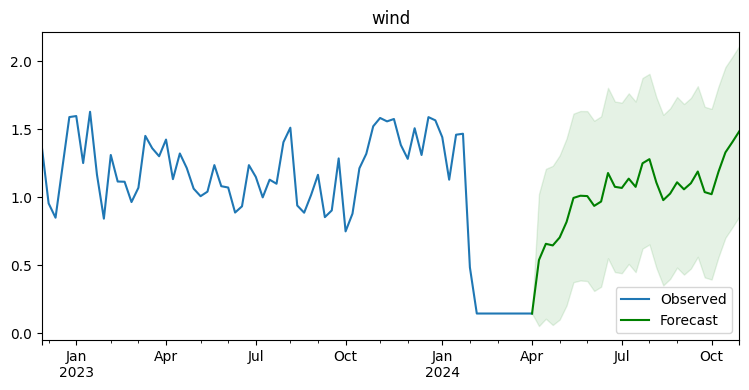

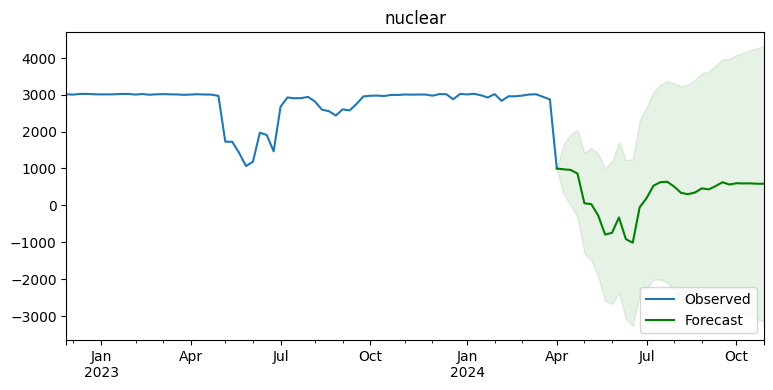

In [35]:
plot_forecast(models, energy_types, 30)